In [376]:
import pandas as pd

main_cities = [line.strip() for line in open("DATASET/main_cities")]

count_cities = {}

In [377]:
import re

def is_new_journey(string):
    regex_header = r"-- ([0-9]+) --"
    matches_it = re.finditer(regex_header, line, re.MULTILINE)
    matches = [m for m in matches_it]
    return len(matches) == 1

regex_line = r"^([0-9]{7}) (.{20}) .([0-9\ ]{5}) .([0-9\ ]{5})"
def is_line_timetable(string):
    matches_it = re.finditer(regex_line, line, re.MULTILINE)
    matches = [m for m in matches_it]
    return len(matches) == 1

def get_line_timetable(line):
    if is_line_timetable(line):
        matches_it = re.finditer(regex_line, line, re.MULTILINE)
        matches = [m for m in matches_it]
        match = matches[0]
        return match.groups()

    return None, None, None, None

def is_start_journey(string):
    return string.strip() == ""


cities = set()
links = []

old = None
with open("DATASET/FPLAN", "r") as f:
    for line in f:
        if is_new_journey(line):
            #print("\n New Journey \n")
            old=None
            pass
        
        if is_line_timetable(line):
            number, name, start_str, end_str = get_line_timetable(line)
            name = name.strip()
            if name == "Haute-Nendaz, téléca":
                name = "Haute-Nendaz, télécabine"
            if name == "Verbier, station pos":
                name = "Verbier, station poste"
            
            count_cities[name.split(",")[0]] = count_cities.get(name.split(",")[0],0) + 1
            if name in main_cities:             
                cities.add(name)
                if old != None:
                    if old < name:
                        links.append((old, name))
                    else:
                        links.append((name, old))
            

                old = name
                          
print(cities)
print(links)

{'Winterthur', 'Biel/Bienne', 'Martigny', 'Vernier', 'Luzern', 'Genève', 'Thun', 'Neuchâtel', 'Sion', 'Schaffhausen', 'Basel SBB', 'St. Gallen', 'Zug', 'Lausanne', 'La Chaux-de-Fonds', 'Bulle', 'Locarno', 'Zürich HB', 'Fribourg/Freiburg', 'Visp', 'Montreux', 'Chur', 'Lugano', 'Bern', 'Uster'}
[('Basel SBB', 'Zürich HB'), ('Basel SBB', 'Zürich HB'), ('Basel SBB', 'Zürich HB'), ('Basel SBB', 'Zürich HB'), ('Bern', 'Thun'), ('Basel SBB', 'Bern'), ('Basel SBB', 'Bern'), ('Bern', 'Thun'), ('Basel SBB', 'Zürich HB'), ('Basel SBB', 'Zürich HB'), ('Basel SBB', 'Zürich HB'), ('Basel SBB', 'Zürich HB'), ('Lugano', 'Zug'), ('Zug', 'Zürich HB'), ('Zug', 'Zürich HB'), ('Lugano', 'Zug'), ('Lugano', 'Zug'), ('Zug', 'Zürich HB'), ('Zug', 'Zürich HB'), ('Lugano', 'Zug'), ('Lugano', 'Zug'), ('Zug', 'Zürich HB'), ('Zug', 'Zürich HB'), ('Lugano', 'Zug'), ('Lugano', 'Zug'), ('Zug', 'Zürich HB'), ('Zug', 'Zürich HB'), ('Lugano', 'Zug'), ('Lugano', 'Zug'), ('Zug', 'Zürich HB'), ('Zug', 'Zürich HB'), ('Lugano

In [378]:
from collections import Counter
count_dict = dict(Counter(links))
count_dict

{('Basel SBB', 'Zürich HB'): 245,
 ('Bern', 'Thun'): 345,
 ('Basel SBB', 'Bern'): 87,
 ('Lugano', 'Zug'): 79,
 ('Zug', 'Zürich HB'): 511,
 ('Montreux', 'Sion'): 10,
 ('Lausanne', 'Montreux'): 240,
 ('Genève', 'Lausanne'): 310,
 ('Thun', 'Visp'): 89,
 ('Chur', 'Zürich HB'): 112,
 ('Basel SBB', 'Luzern'): 115,
 ('Lugano', 'Luzern'): 30,
 ('Schaffhausen', 'Zürich HB'): 132,
 ('St. Gallen', 'Winterthur'): 165,
 ('Winterthur', 'Zürich HB'): 742,
 ('Biel/Bienne', 'Neuchâtel'): 171,
 ('Genève', 'Neuchâtel'): 38,
 ('Biel/Bienne', 'Zürich HB'): 111,
 ('Lausanne', 'Neuchâtel'): 83,
 ('Locarno', 'Luzern'): 4,
 ('Bern', 'Fribourg/Freiburg'): 195,
 ('Fribourg/Freiburg', 'Lausanne'): 81,
 ('Bern', 'Zürich HB'): 172,
 ('Lugano', 'Zürich HB'): 9,
 ('Basel SBB', 'Biel/Bienne'): 35,
 ('Martigny', 'Sion'): 215,
 ('Martigny', 'Montreux'): 138,
 ('Sion', 'Visp'): 197,
 ('Luzern', 'Zug'): 436,
 ('Bern', 'Luzern'): 44,
 ('Chur', 'St. Gallen'): 30,
 ('Bern', 'Biel/Bienne'): 160,
 ('Biel/Bienne', 'La Chaux-de-

In [379]:
from datetime import date

regex_geo = r"^[0-9]{7} +([0-9\.\-]+)  +([0-9\.\-]+) .+\% (.+)"
def get_groups(string, regex): 
    matches_it = re.finditer(regex, string, re.MULTILINE)
    matches = [m for m in matches_it]
    match = matches[0]
    return match.groups()

cities_to_point = pd.DataFrame([], columns=["name", "long","lat", "date", "radius"])
with open("DATASET/BFKOORD_GEO", "r") as f:
    for line in f: 
        y,x,name = get_groups(line, regex_geo)
        if name in main_cities:
            cities_to_point = cities_to_point.append({"name" : name, "lat" : float(x), "long" :float(y), "date": date.today(), "radius" : 10}, ignore_index=True)
        
cities_to_point
map_name_to_coor = {r[1][0] : (r[1][1], r[1][2])for r in cities_to_point.iterrows()}
print(map_name_to_coor)

{'Basel SBB': (7.589551, 47.547405), 'Vernier': (6.093894, 46.22071), 'Genève': (6.142452, 46.210203), 'Lausanne': (6.629093, 46.516779), 'Montreux': (6.910432, 46.435875), 'Martigny': (7.079122, 46.105828), 'Sion': (7.359191, 46.227546), 'Visp': (7.881458, 46.294025), 'Zug': (8.515295, 47.173624), 'Zürich HB': (8.540192, 47.378177), 'Uster': (8.718688, 47.350367), 'Schaffhausen': (8.632728, 47.698282), 'Bulle': (7.055037, 46.618189), 'Fribourg/Freiburg': (7.151023, 46.803268), 'Neuchâtel': (6.935705, 46.996723), 'Biel/Bienne': (7.242908, 47.132893), 'La Chaux-de-Fonds': (6.826018, 47.098644), 'Luzern': (8.31017, 47.05017), 'Lugano': (8.946874, 46.005506), 'Locarno': (8.801358, 46.172428), 'Winterthur': (8.723799, 47.500334), 'St. Gallen': (9.369877, 47.42318), 'Bern': (7.439118, 46.948825), 'Thun': (7.629594, 46.754854), 'Chur': (9.528925, 46.85308)}


In [380]:
links_df =[{"name": k, "weight": v, "coordinates" :[map_name_to_coor[c] for c in k]} for k,v in count_dict.items()]


from geojson import LineString, Feature, FeatureCollection
coll = FeatureCollection([Feature(geometry=LineString(l["coordinates"]), properties={"weight": l["weight"]}) for l in links_df])



In [381]:
from mapboxgl.viz import *
from mapboxgl.utils import *
token = (open(".mapbox_access_token").read().strip())
points = df_to_geojson(cities_to_point, lat='lat', lon='long', precision=3)

print(points)

color_breaks = [0,9,100,1000,10000]
color_stops = create_color_stops(color_breaks, colors='YlGnBu')
# Create the viz from the dataframe
viz = CircleViz(points,
                access_token=token,
                stroke_color='black',
                stroke_width=0.5,
                radius=4,
                center=(8, 47),
                zoom=7,
                style="mapbox://styles/harne/ck50szq0t0hpl1cmx9hxbfz7h")
viz.show()

{"features": [{"geometry": {"coordinates": [7.59, 47.547], "type": "Point"}, "properties": {"date": 1578441600, "name": "Basel SBB", "radius": 10}, "type": "Feature"}, {"geometry": {"coordinates": [6.094, 46.221], "type": "Point"}, "properties": {"date": 1578441600, "name": "Vernier", "radius": 10}, "type": "Feature"}, {"geometry": {"coordinates": [6.142, 46.21], "type": "Point"}, "properties": {"date": 1578441600, "name": "Gen\u00e8ve", "radius": 10}, "type": "Feature"}, {"geometry": {"coordinates": [6.629, 46.517], "type": "Point"}, "properties": {"date": 1578441600, "name": "Lausanne", "radius": 10}, "type": "Feature"}, {"geometry": {"coordinates": [6.91, 46.436], "type": "Point"}, "properties": {"date": 1578441600, "name": "Montreux", "radius": 10}, "type": "Feature"}, {"geometry": {"coordinates": [7.079, 46.106], "type": "Point"}, "properties": {"date": 1578441600, "name": "Martigny", "radius": 10}, "type": "Feature"}, {"geometry": {"coordinates": [7.359, 46.228], "type": "Point"}

/usr/local/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [382]:
print(coll)
viz = LinestringViz(coll,
            access_token=token,
            center=(8, 47),
            zoom=7,
            line_width_property='weight',
            line_width_stops=create_numeric_stops([0,1,5, 50, 100, 200,500,1000,  1500], 0, 20),   
            color_property='weight',
            color_stops=create_color_stops([0,1,5,  50, 100, 200,500,1000,  1500], colors='Blues'),
            opacity = 0.8,
            style="mapbox://styles/harne/ck50szq0t0hpl1cmx9hxbfz7h",
            box_zoom_on = False,
            )
viz.show()

{"features": [{"geometry": {"coordinates": [[7.589551, 47.547405], [8.540192, 47.378177]], "type": "LineString"}, "properties": {"weight": 245}, "type": "Feature"}, {"geometry": {"coordinates": [[7.439118, 46.948825], [7.629594, 46.754854]], "type": "LineString"}, "properties": {"weight": 345}, "type": "Feature"}, {"geometry": {"coordinates": [[7.589551, 47.547405], [7.439118, 46.948825]], "type": "LineString"}, "properties": {"weight": 87}, "type": "Feature"}, {"geometry": {"coordinates": [[8.946874, 46.005506], [8.515295, 47.173624]], "type": "LineString"}, "properties": {"weight": 79}, "type": "Feature"}, {"geometry": {"coordinates": [[8.515295, 47.173624], [8.540192, 47.378177]], "type": "LineString"}, "properties": {"weight": 511}, "type": "Feature"}, {"geometry": {"coordinates": [[6.910432, 46.435875], [7.359191, 46.227546]], "type": "LineString"}, "properties": {"weight": 10}, "type": "Feature"}, {"geometry": {"coordinates": [[6.629093, 46.516779], [6.910432, 46.435875]], "type"

In [383]:
viz.__dict__

{'access_token': 'pk.eyJ1IjoiaGFybmUiLCJhIjoiY2oxejQ0Yzd1MDFleDJ3azJzem5tZzRyeCJ9.fXoksm1YeRxCflOpeCMpNg',
 'data': {"features": [{"geometry": {"coordinates": [[7.589551, 47.547405], [8.540192, 47.378177]], "type": "LineString"}, "properties": {"weight": 245}, "type": "Feature"}, {"geometry": {"coordinates": [[7.439118, 46.948825], [7.629594, 46.754854]], "type": "LineString"}, "properties": {"weight": 345}, "type": "Feature"}, {"geometry": {"coordinates": [[7.589551, 47.547405], [7.439118, 46.948825]], "type": "LineString"}, "properties": {"weight": 87}, "type": "Feature"}, {"geometry": {"coordinates": [[8.946874, 46.005506], [8.515295, 47.173624]], "type": "LineString"}, "properties": {"weight": 79}, "type": "Feature"}, {"geometry": {"coordinates": [[8.515295, 47.173624], [8.540192, 47.378177]], "type": "LineString"}, "properties": {"weight": 511}, "type": "Feature"}, {"geometry": {"coordinates": [[6.910432, 46.435875], [7.359191, 46.227546]], "type": "LineString"}, "properties": {"w

In [384]:
{k: v for k, v in sorted(count_cities.items(), key=lambda item: item[1], reverse=True)}

{'Bern': 133558,
 'Luzern': 87036,
 'Fribourg': 58427,
 'Schaffhausen': 53279,
 'Neuchâtel': 51603,
 'Zug': 33134,
 'La Chaux-de-Fonds': 27821,
 'Baden': 27361,
 'Lugano': 22256,
 'Chur': 19118,
 'Basel': 19057,
 'Kriens': 16251,
 'Wil SG': 15648,
 'Baar': 14083,
 'Solothurn': 13784,
 'Villars-sur-Glâne': 12691,
 'Olten': 11418,
 'Ostermundigen': 11226,
 'Ebikon': 11187,
 'Emmenbrücke': 10727,
 'La Chaux-de-F': 10313,
 'Neuhausen': 9906,
 'Wettingen': 9902,
 'Aarau': 9632,
 'Cham': 9450,
 'Bellinzona': 9177,
 'Nyon': 8833,
 'Münchenstein': 7952,
 'Köniz': 7308,
 'Grenchen': 7241,
 'Sion': 7155,
 'Reinach BL': 7028,
 'Altstätten SG': 6608,
 'Le Locle': 6448,
 'Horw': 6383,
 'St. Gallen': 6334,
 'Burgdorf': 6262,
 'Liebefeld': 6120,
 'Oberwil BL': 5851,
 'Zofingen': 5740,
 'Buchs SG': 5530,
 'Littau': 5221,
 'Davos Platz': 5127,
 'Steinhausen': 4954,
 'Schaan': 4939,
 'Wohlen AG': 4861,
 'Marly': 4570,
 'Davos Dorf': 4445,
 'Mendrisio': 4398,
 'Küssnacht am Rigi': 4388,
 'Rheinfelden': 4

In [385]:
map_name_to_coor
links_df

[{'name': ('Basel SBB', 'Zürich HB'),
  'weight': 245,
  'coordinates': [(7.589551, 47.547405), (8.540192, 47.378177)]},
 {'name': ('Bern', 'Thun'),
  'weight': 345,
  'coordinates': [(7.439118, 46.948825), (7.629594, 46.754854)]},
 {'name': ('Basel SBB', 'Bern'),
  'weight': 87,
  'coordinates': [(7.589551, 47.547405), (7.439118, 46.948825)]},
 {'name': ('Lugano', 'Zug'),
  'weight': 79,
  'coordinates': [(8.946874, 46.005506), (8.515295, 47.173624)]},
 {'name': ('Zug', 'Zürich HB'),
  'weight': 511,
  'coordinates': [(8.515295, 47.173624), (8.540192, 47.378177)]},
 {'name': ('Montreux', 'Sion'),
  'weight': 10,
  'coordinates': [(6.910432, 46.435875), (7.359191, 46.227546)]},
 {'name': ('Lausanne', 'Montreux'),
  'weight': 240,
  'coordinates': [(6.629093, 46.516779), (6.910432, 46.435875)]},
 {'name': ('Genève', 'Lausanne'),
  'weight': 310,
  'coordinates': [(6.142452, 46.210203), (6.629093, 46.516779)]},
 {'name': ('Thun', 'Visp'),
  'weight': 89,
  'coordinates': [(7.629594, 46.7

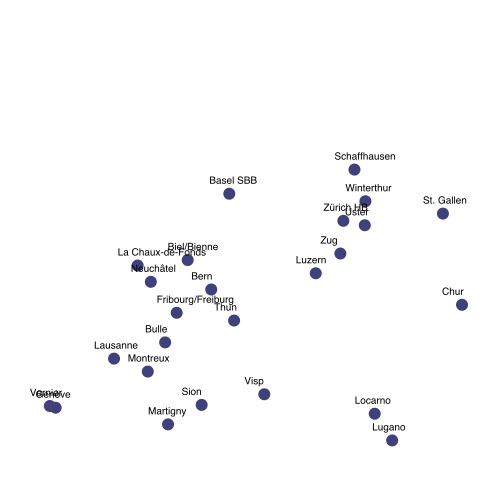

In [386]:
svgio = BytesIO()
side = 500
import IPython.display

from io import BytesIO
import numpy as np
import cairo

x_bar = cities_to_point["long"].mean()
y_bar = cities_to_point["lat"].mean()

transform_X = lambda x : (x-x_bar)*120+side/2 
transform_Y = lambda y : 60 - (v[1]-y_bar)*160+side/2


palette = [
    [64/255, 64/255, 122/255,1.0],
    [255/255, 121/255, 63/255,1.0],
    [255/255, 177/255, 66/255,1.0],
    [52/255, 172/255, 224/255,1.0],
    
]
with cairo.SVGSurface(svgio, side, side) as surface:
    context = cairo.Context(surface)

    for k,v in map_name_to_coor.items():
        X, Y = transform_X(v[0]), transform_Y(v[1])
        context.arc(X, Y, 6, 0, 2*np.pi)
        context.set_source_rgba(*palette[0])
        context.fill()
        
    context.set_source_rgba(0,0,0,1)
    
    for k,v in map_name_to_coor.items():
        X, Y = transform_X(v[0]), transform_Y(v[1])
        context.move_to(X-20,Y-10)
        context.show_text(k)
        context.stroke()
        
#for link in links_df:
   #     coord, weight = link["coordinates"], link["weight"]
        #X1,Y1,X2,Y2 = transform_X(coord[0][0]), transform_Y(coord[0][1]), transform_X(coord[1][0]), transform_Y(coord[1][1])
        #context.move_to(X1, Y1)
        #context.line_to(X2, Y2) 
        #print(X1,X2,Y1,Y2)
        #context.set_line_width(weight/20)
        #context.stroke()

IPython.display.SVG(data=svgio.getvalue())

In [387]:
cities_to_point["long"].mean()

7.76210008

In [388]:
map_name_to_coor

{'Basel SBB': (7.589551, 47.547405),
 'Vernier': (6.093894, 46.22071),
 'Genève': (6.142452, 46.210203),
 'Lausanne': (6.629093, 46.516779),
 'Montreux': (6.910432, 46.435875),
 'Martigny': (7.079122, 46.105828),
 'Sion': (7.359191, 46.227546),
 'Visp': (7.881458, 46.294025),
 'Zug': (8.515295, 47.173624),
 'Zürich HB': (8.540192, 47.378177),
 'Uster': (8.718688, 47.350367),
 'Schaffhausen': (8.632728, 47.698282),
 'Bulle': (7.055037, 46.618189),
 'Fribourg/Freiburg': (7.151023, 46.803268),
 'Neuchâtel': (6.935705, 46.996723),
 'Biel/Bienne': (7.242908, 47.132893),
 'La Chaux-de-Fonds': (6.826018, 47.098644),
 'Luzern': (8.31017, 47.05017),
 'Lugano': (8.946874, 46.005506),
 'Locarno': (8.801358, 46.172428),
 'Winterthur': (8.723799, 47.500334),
 'St. Gallen': (9.369877, 47.42318),
 'Bern': (7.439118, 46.948825),
 'Thun': (7.629594, 46.754854),
 'Chur': (9.528925, 46.85308)}

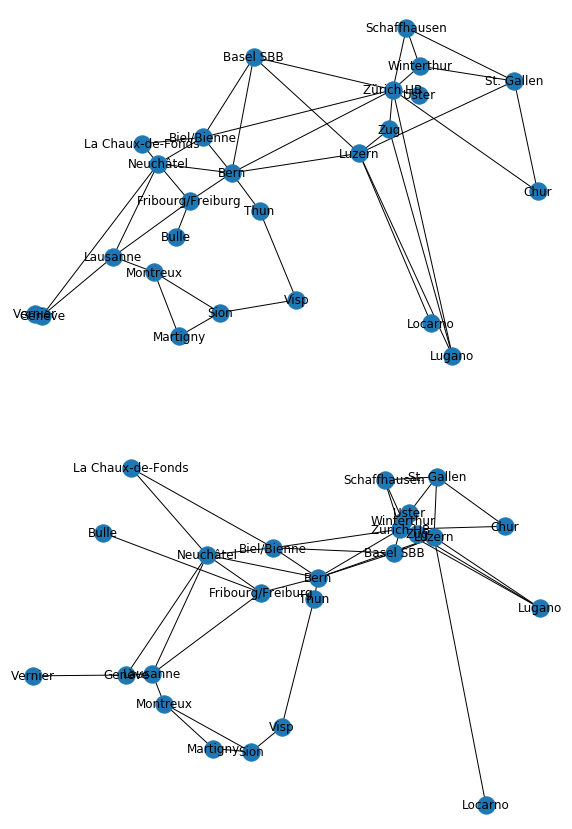

In [389]:
import networkx as nx
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,15)) 

G = nx.Graph()
G.add_nodes_from(map_name_to_coor.keys())
edges = [(l["name"], l["weight"]) for l in  links_df]
for l in links_df:
    G.add_edge(*l["name"], weight=l["weight"])
nx.draw(G, map_name_to_coor, with_labels=True, ax=axes[0])


weight_matrix = {}

for l in links_df:
    weight_matrix[l["name"][0]] = weight_matrix.get(l["name"][0], {})
    weight_matrix[l["name"][1]] = weight_matrix.get(l["name"][1], {})
    weight_matrix[l["name"][0]][l["name"][1]] = l["weight"]
    weight_matrix[l["name"][1]][l["name"][0]] = l["weight"]
    
dist_matrix = {}

for nr in G:
    dist_matrix[nr] = {}
    weight_matrix[nr] = weight_matrix.get(nr,{})
    for nc in G:
        dist_matrix[nr][nc] = 1/weight_matrix[nr].get(nc, 17) *1000

#print(dist_matrix)

from networkx.drawing.layout import kamada_kawai_layout
np.random.seed(seed=400)

layout = kamada_kawai_layout(
    G,
    scale=100,
    dist=dist_matrix,
    center=[10,0], 
    pos=map_name_to_coor)

nx.draw(G,layout,with_labels=True, ax=axes[1])
plt.show()

fig.savefig('../../latex/thesis_template/figures/CFF-NewDistances.pdf')